In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import os
import random
from torch.autograd import Variable
import copy
from torch import nn, optim
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import csv
import time
import math


In [2]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
fix_seed(SEED)

In [3]:
class Argments():
  def __init__(self):
    self.batch_size = 40
    self.test_batch = 1000
    self.global_epochs = 500
    self.local_epochs = 2
    self.lamda = 15
    self.K = 5
    self.lr = None
    self.momentum = 0.9
    self.weight_decay = 10**-4.0
    self.clip = 20.0
    self.partience = 500
    self.worker_num = 20
    self.sample_num = 20
    self.unlabeleddata_size = 1000
    self.device = torch.device('cuda:0'if torch.cuda.is_available() else'cpu')
    self.criterion = nn.CrossEntropyLoss()
    
    self.alpha_label = 0.5
    self.alpha_size = 10

args = Argments()

In [4]:
# Tuned value
lr = 1

In [6]:
lr_list = []
lr_list.append(10**-3.0)
lr_list.append(10**-2.5)
lr_list.append(10**-2.0)
lr_list.append(10**-1.5)
lr_list.append(10**-1.0)
lr_list.append(10**-0.5)
lr_list.append(10**0.0)
lr_list.append(10**0.5)

args.lr = lr_list[lr]

In [9]:
class LocalDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.data = []
        self.label = []

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]
        if self.transform:
            out_data = self.transform(out_data)
        return out_data, out_label
    
class DatasetFromSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)
    
class GlobalDataset(torch.utils.data.Dataset):
  def __init__(self,federated_dataset,transform=None):
    self.transform = transform
    self.data = []
    self.label = []
    for dataset in federated_dataset:
      for (data,label) in dataset:
        self.data.append(data)
        self.label.append(label)

  def __getitem__(self, idx):
    out_data = self.data[idx]
    out_label = self.label[idx]
    if self.transform:
        out_data = self.transform(out_data)
    return out_data, out_label

  def __len__(self):
    return len(self.data)

class UnlabeledDataset(torch.utils.data.Dataset):
  def __init__(self,transform=None):
    self.transform = transform
    self.data = []
    self.target = None

  def __getitem__(self, idx):
    out_data = self.data[idx]
    out_label = 'unlabeled'
    if self.transform:
        out_data = self.transform(out_data)
    return out_data, out_label

  def __len__(self):
    return len(self.data)

In [10]:
def get_dataset(Centralized=False,unlabeled_data=False):
    
    transform_train = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomCrop(32, padding=2),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.491372549, 0.482352941, 0.446666667), (0.247058824, 0.243529412, 0.261568627))])
    transform_test = transforms.Compose([transforms.ToPILImage(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.491372549, 0.482352941, 0.446666667), (0.247058824, 0.243529412, 0.261568627))])

    # download train data
    all_trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True)
    #trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

    # download test data
    all_testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True)
    #testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

    
    ## get unlabeled dataset
    if unlabeled_data:
        unlabeled_dataset = UnlabeledDataset(transform_test)
        idx = sorted(random.sample(range(len(all_trainset)),args.unlabeleddata_size))
        unlabeled_dataset.data = np.array([all_trainset.data[i]  for i in idx])
        all_trainset.data = np.delete(all_trainset.data,idx,0)
        all_trainset.targets = np.delete(all_trainset.targets,idx,0)
    all_train_data = np.array(all_trainset.data)
    all_train_label = np.array(all_trainset.targets)
    all_test_data = np.array(all_testset.data)
    all_test_label = np.array(all_testset.targets)
    print('Train:{} Test:{}'.format(len(all_train_data),len(all_test_data)))


    ## Data size heterogeneity
    data_proportions = np.random.dirichlet(np.repeat(args.alpha_size, args.worker_num))
    train_data_proportions = np.array([0 for _ in range(args.worker_num)])
    test_data_proportions = np.array([0 for _ in range(args.worker_num)])
    for i in range(len(data_proportions)):
        if i==(len(data_proportions)-1):
            train_data_proportions = train_data_proportions.astype('int64')
            test_data_proportions = test_data_proportions.astype('int64')
            train_data_proportions[-1] = len(all_train_data) - np.sum(train_data_proportions[:-1])
            test_data_proportions[-1] = len(all_test_data) - np.sum(test_data_proportions[:-1])
        else:
            train_data_proportions[i] = (data_proportions[i] * len(all_train_data))
            test_data_proportions[i] = (data_proportions[i] * len(all_test_data))
    min_size = 0
    K = 10

    '''
    label_list = np.arange(10)
    np.random.shuffle(label_list)
    '''
    label_list = list(range(K))


    ## Data distribution heterogeneity
    while min_size<10:
        idx_train_batch = [[] for _ in range(args.worker_num)]
        idx_test_batch = [[] for _ in range(args.worker_num)]
        for k in label_list:
            proportions_train = np.random.dirichlet(np.repeat(args.alpha_label, args.worker_num))
            proportions_test = copy.deepcopy(proportions_train)
            idx_k_train = np.where(all_train_label == k)[0]
            idx_k_test = np.where(all_test_label == k)[0]
            np.random.shuffle(idx_k_train)
            np.random.shuffle(idx_k_test)
            ## Balance (train)
            proportions_train = np.array([p*(len(idx_j)<train_data_proportions[i]) for i,(p,idx_j) in enumerate(zip(proportions_train,idx_train_batch))])
            proportions_train = proportions_train/proportions_train.sum()
            proportions_train = (np.cumsum(proportions_train)*len(idx_k_train)).astype(int)[:-1]
            idx_train_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_train_batch,np.split(idx_k_train,proportions_train))]

            ## Balance (test)
            proportions_test = np.array([p*(len(idx_j)<test_data_proportions[i]) for i,(p,idx_j) in enumerate(zip(proportions_test,idx_test_batch))])
            proportions_test = proportions_test/proportions_test.sum()
            proportions_test = (np.cumsum(proportions_test)*len(idx_k_test)).astype(int)[:-1]
            idx_test_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_test_batch,np.split(idx_k_test,proportions_test))]

            min_size = min([len(idx_j) for idx_j in idx_train_batch])

    federated_trainset = []
    federated_testset = []
    for i in range(args.worker_num):
        ## create trainset
        data = [all_train_data[idx] for idx in idx_train_batch[i]]
        label = [all_train_label[idx] for idx in idx_train_batch[i]]
        federated_trainset.append(LocalDataset())
        federated_trainset[-1].data = data
        federated_trainset[-1].label = label

        ## create testset
        data = [all_test_data[idx] for idx in idx_test_batch[i]]
        label = [all_test_label[idx] for idx in idx_test_batch[i]]
        federated_testset.append(LocalDataset())
        federated_testset[-1].data = data
        federated_testset[-1].label = label

        
    ## split trainset
    federated_valset = [None]*args.worker_num
    for i in range(args.worker_num):
        n_samples = len(federated_trainset[i])
        if n_samples==1:
            train_subset = federated_trainset[i]
            val_subset = copy.deepcopy(federated_trainset[i])
        else:
            train_size = int(len(federated_trainset[i]) * 0.8) 
            val_size = n_samples - train_size 
            train_subset,val_subset = torch.utils.data.random_split(federated_trainset[i], [train_size, val_size])

        federated_trainset[i] = DatasetFromSubset(train_subset)
        federated_valset[i] = DatasetFromSubset(val_subset)

    ## show data distribution
    H = 4
    W = 5
    fig, axs = plt.subplots(H, W, figsize=(20, 5))
    x = np.arange(1,11)
    for i, (trainset,valset,testset) in enumerate(zip(federated_trainset,federated_valset,federated_testset)):
        bottom = [0]*10
        count = [0]*10
        for _,label in trainset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        for j in range(len(count)):
            bottom[j]+=count[j]
        count = [0]*10
        for _,label in valset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        for j in range(len(count)):
            bottom[j]+=count[j]
        count = [0]*10
        for _,label in testset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        #axs[int(i/W), i%W].title("worker{}".format(i+1), fontsize=12, color = "green")

    plt.show()

    ## get global dataset
    if Centralized:
        global_trainset = GlobalDataset(federated_trainset)
        global_valset = GlobalDataset(federated_valset)
        global_testset =  GlobalDataset(federated_testset)
        
        #show_cifer(global_trainset.data,global_testset.label, cifar10_labels)

        global_trainset.transform = transform_train
        global_valset.transform = transform_test
        global_testset.transform = transform_test

        global_trainloader = torch.utils.data.DataLoader(global_trainset,batch_size=args.batch_size,shuffle=True,num_workers=2)
        global_valloader = torch.utils.data.DataLoader(global_valset,batch_size=args.test_batch,shuffle=False,num_workers=2)
        global_testloader = torch.utils.data.DataLoader(global_testset,batch_size=args.test_batch,shuffle=False,num_workers=2)

    ## set transform
    for i in range(args.worker_num):
        federated_trainset[i].transform = transform_train
        federated_valset[i].transform = transform_test
        federated_testset[i].transform = transform_test
    
    if Centralized and unlabeled_data:
        return federated_trainset,federated_valset,federated_testset,global_trainloader,global_valloader,global_testloader,unlabeled_dataset
    if Centralized:
        return federated_trainset,federated_valset,federated_testset,global_trainloader,global_valloader,global_testloader
    elif unlabeled_data:
        return federated_trainset,federated_valset,federated_testset,unlabeled_dataset
    else:
        return federated_trainset,federated_valset,federated_testset

Files already downloaded and verified
Files already downloaded and verified
Train:49000 Test:10000


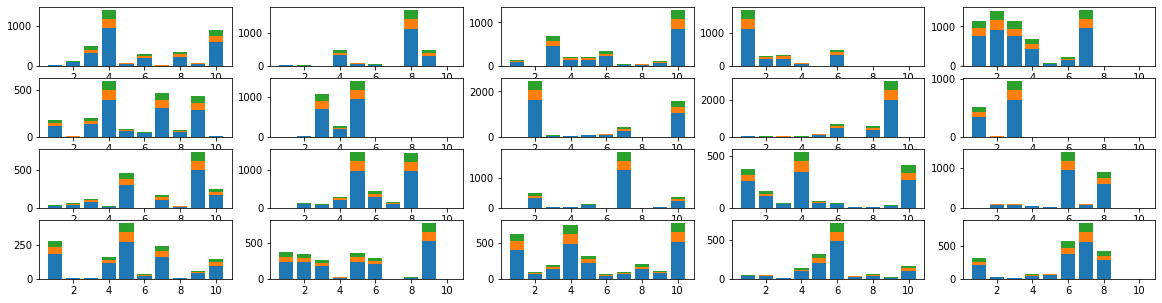

In [11]:
federated_trainset,federated_valset,federated_testset,unlabeled_dataset = get_dataset(unlabeled_data=True)

In [12]:
total = [0,0,0]
for i in range(args.worker_num):
    total[0]+=len(federated_trainset[i])
    total[1]+=len(federated_valset[i])
    total[2]+=len(federated_testset[i])
print(total)

[39191, 9809, 10000]


In [14]:
class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            #print("in_channels: {}, v: {}".format(in_channels, v))
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}


class VGGConvBlocks(nn.Module):
    '''
    VGG containers that only contains the conv layers 
    '''
    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

class VGGContainer(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features, input_dim, hidden_dims, num_classes=10):
        super(VGGContainer, self).__init__()
        self.features = features
        # note: we hard coded here a bit by assuming we only have two hidden layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(True),
            nn.Linear(hidden_dims[1], num_classes),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def matched_vgg11(matched_shapes):
    # [(67, 27), (67,), (132, 603), (132,), (260, 1188), (260,), (261, 2340), (261,), (516, 2349), (516,), (517, 4644), (517,), 
    # (516, 4653), (516,), (516, 4644), (516,), (516, 515), (515,), (515, 515), (515,), (515, 10), (10,)]
    processed_matched_shape = [matched_shapes[0][0], 
                                'M', 
                                matched_shapes[2][0], 
                                'M', 
                                matched_shapes[4][0], 
                                matched_shapes[6][0], 
                                'M', 
                                matched_shapes[8][0], 
                                matched_shapes[10][0], 
                                'M', 
                                matched_shapes[12][0], 
                                matched_shapes[14][0], 
                                'M']
    return VGGContainer(make_layers(processed_matched_shape), input_dim=matched_shapes[16][0], 
            hidden_dims=[matched_shapes[16][1], matched_shapes[18][1]], num_classes=10)


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn(num_classes=10):
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True), num_classes=num_classes)


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

In [15]:
class pFedMeOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01, lamda=0.1 , mu = 0.001):
        #self.local_weight_updated = local_weight # w_i,K
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        defaults = dict(lr=lr, lamda=lamda, mu = mu)
        super(pFedMeOptimizer, self).__init__(params, defaults)
    
    def step(self, local_weight_updated, closure=None):
        loss = None
        if closure is not None:
            loss = closure
        weight_update = local_weight_updated.copy()
        for group in self.param_groups:
            for p, localweight in zip( group['params'], weight_update):
                localweight.data = localweight.data.to(args.device)
                p.data = p.data - group['lr'] * (p.grad.data + group['lamda'] * (p.data - localweight.data) + group['mu']*p.data)
                localweight.data = localweight.data.to('cpu')
        return  group['params'], loss
    
    def update_param(self, local_weight_updated, closure=None):
        loss = None
        if closure is not None:
            loss = closure
        weight_update = local_weight_updated.copy()
        for group in self.param_groups:
            for p, localweight in zip( group['params'], weight_update):
                p.data = localweight.data
        #return  p.data
        return  group['params']

In [17]:
class Server():
  def __init__(self):
    self.model = vgg13()

  def create_worker(self,federated_trainset,federated_valset,federated_testset):
    workers = []
    for i in range(args.worker_num):
      workers.append(Worker(federated_trainset[i],federated_valset[i],federated_testset[i]))
    return workers

  def sample_worker(self,workers):
    sample_worker = []
    sample_worker_num = random.sample(range(args.worker_num),args.sample_num)
    for i in sample_worker_num:
      sample_worker.append(workers[i])
    return sample_worker


  def send_model(self,workers):
    nums = 0
    for worker in workers:
      nums += worker.train_data_num

    for worker in workers:
      worker.aggregation_weight = 1.0*worker.train_data_num/nums
      worker.model = copy.deepcopy(self.model)
      worker.personalized_model = copy.deepcopy(self.model)
      worker.local_model = copy.deepcopy(self.model)

  def aggregate_model(self,workers):   
    new_params = OrderedDict()
    for i,worker in enumerate(workers):
      worker_state = worker.model.state_dict()
      for key in worker_state.keys():
        if i==0:
          new_params[key] = worker_state[key]*worker.aggregation_weight
        else:
          new_params[key] += worker_state[key]*worker.aggregation_weight
    self.model.load_state_dict(new_params)
    
  def send_parameters(self,workers):
    nums = 0
    for worker in workers:
      nums += worker.train_data_num
    for worker in workers:
        worker.aggregation_weight = 1.0*worker.train_data_num/nums
        worker.set_parameters(self.model)

In [18]:
class Worker():
  def __init__(self,trainset,valset,testset):
    self.trainloader = torch.utils.data.DataLoader(trainset,batch_size=args.batch_size,shuffle=True,num_workers=2)
    self.valloader = torch.utils.data.DataLoader(valset,batch_size=args.test_batch,shuffle=False,num_workers=2)
    self.testloader = torch.utils.data.DataLoader(testset,batch_size=args.test_batch,shuffle=False,num_workers=2)
    #self.iter_trainloader = iter(self.trainloader)
    self.model = vgg13()
    self.local_model = copy.deepcopy(list(self.model.parameters()))
    self.persionalized_model = copy.deepcopy(list(self.model.parameters()))
    self.persionalized_model_bar = copy.deepcopy(list(self.model.parameters()))
    self.train_data_num = len(trainset)
    self.test_data_num = len(testset)
    
    self.optimizer = pFedMeOptimizer(self.model.parameters(),lr=args.lr,lamda=args.lamda)
    
  def set_parameters(self, model):
    for old_param, new_param, local_param in zip(self.model.parameters(), model.parameters(), self.local_model):
        old_param.data = new_param.data.clone()
        local_param.data = new_param.data.clone()
    #self.local_weight_updated = copy.deepcopy(self.optimizer.param_groups[0]['params'])
    
  def get_next_train_batch(self):
    try:
        # Samples a new batch for persionalizing
        (X, y) = next(self.iter_trainloader)
    except StopIteration:
        # restart the generator if the previous generator is exhausted.
        self.iter_trainloader = iter(self.trainloader)
        (X, y) = next(self.iter_trainloader)
    return (X.to(args.device), y.to(args.device))    
  '''
  def local_train(self):
    self.model.train()
    optimizer = pFedMeOptimizer(self.model.parameters(),lr=args.lr,lamda=args.lamda)
    for epoch in range(args.local_epochs):
        running_loss = 0.0
        correct = 0
        count = 0
        data,labels = self.get_next_train_batch()
        for i in range(args.K):
            self.model = self.model.to(args.device)
            optimizer.zero_grad()
            outputs = self.model(data)
            loss = args.criterion(outputs,labels)
            running_loss += loss.item()
            predicted = torch.argmax(outputs,dim=1)
            correct += (predicted==labels).sum().item()
            count += len(labels)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(self.model.parameters(), args.clip)
            self.model = self.model.to('cpu')
            personal_model,_ = optimizer.step(self.local_model)
        
        for new_param,localweight in zip(personal_model,self.local_model.parameters()):
            localweight.data = localweight.data - args.lamda * args.lr * (localweight.data - new_param.data)    
    
    del self.model
    
    update_parameters(self.personalized_model,personal_model)
    return 100.0*correct/count,running_loss/len(self.trainloader)
  '''

  def local_train(self):
    self.model.train() 
    self.model = self.model.to(args.device)       
    for epoch in range(args.local_epochs):
        running_loss = 0.0
        correct = 0
        count = 0
        for (data,labels) in self.trainloader:
            self.model.train()
            data,labels = Variable(data),Variable(labels)
            data,labels = data.to(args.device),labels.to(args.device)
            for k in range(args.K):
                self.optimizer.zero_grad()
                outputs = self.model(data)
                loss = args.criterion(outputs,labels)
                if k==(args.K-1):
                    running_loss += loss.item()
                    predicted = torch.argmax(outputs,dim=1)
                    correct += (predicted==labels).sum().item()
                    count += len(labels)
                loss.backward()
                #torch.nn.utils.clip_grad_norm_(self.model.parameters(), args.clip)
                self.persionalized_model_bar,_ = self.optimizer.step(self.local_model)
        
            for new_param, localweight in zip(self.persionalized_model_bar, self.local_model):
                localweight.data = localweight.data.to(args.device)
                localweight.data = localweight.data - args.lamda* args.lr * (localweight.data - new_param.data)
                localweight.data = localweight.data.to('cpu')
    
    self.update_parameters(self.local_model)
    
    self.model = self.model.to('cpu')
    for personal_weight, localweight in zip(self.persionalized_model_bar, self.local_model):
        personal_weight.data = personal_weight.data.to('cpu')
        localweight.data = localweight.data.to('cpu')
        
    return 100.0*correct/count,running_loss/len(self.trainloader)


  def validate(self):
    self.model.eval()
    self.update_parameters(self.persionalized_model_bar)
    self.model = self.model.to(args.device)
    acc,loss = test(self.model,args.criterion,self.valloader)
    self.model = self.model.to('cpu')
    self.update_parameters(self.local_model)
    return acc,loss


  def test(self):
    self.model.eval()
    self.update_parameters(self.persionalized_model_bar)
    self.model = self.model.to(args.device)
    acc,loss = test(self.model,args.criterion,self.testloader)
    self.model = self.model.to('cpu')
    self.update_parameters(self.local_model)
    return acc,loss


  def update_parameters(self, new_params):
    for param , new_param in zip(self.model.parameters(), new_params):
      param.data = new_param.data.clone()

In [19]:
def train(model,criterion,trainloader,epochs):
  optimizer = optim.SGD(model.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay)
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    count = 0
    for (data,labels) in trainloader:
      data,labels = Variable(data),Variable(labels)
      data,labels = data.to(args.device),labels.to(args.device)
      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs,labels)
      running_loss += loss.item()
      predicted = torch.argmax(outputs,dim=1)
      correct += (predicted==labels).sum().item()
      count += len(labels)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
      optimizer.step()

  return 100.0*correct/count,running_loss/len(trainloader)



In [20]:
def test(model,criterion,testloader):
  model.eval()
  running_loss = 0.0
  correct = 0
  count = 0
  for (data,labels) in testloader:
    data,labels = data.to(args.device),labels.to(args.device)
    outputs = model(data)
    running_loss += criterion(outputs,labels).item()
    predicted = torch.argmax(outputs,dim=1)
    correct += (predicted==labels).sum().item()
    count += len(labels)

  accuracy = 100.0*correct/count
  loss = running_loss/len(testloader)


  return accuracy,loss

In [21]:
class Early_Stopping():
  def __init__(self,partience):
    self.step = 0
    self.loss = float('inf')
    self.partience = partience

  def validate(self,loss):
    if self.loss<loss:
      self.step += 1
      if self.step>self.partience:
        return True
    else:
      self.step = 0
      self.loss = loss

    return False

In [22]:
server = Server()
workers = server.create_worker(federated_trainset,federated_valset,federated_testset)
acc_train = []
loss_train = []
acc_valid = []
loss_valid = []

early_stopping = Early_Stopping(args.partience)

start = time.time()

for epoch in range(args.global_epochs):
  sample_worker = server.sample_worker(workers)
  server.send_parameters(sample_worker)

  acc_train_avg = 0.0
  loss_train_avg = 0.0
  acc_valid_avg = 0.0
  loss_valid_avg = 0.0
  for worker in sample_worker:
    acc_train_tmp,loss_train_tmp = worker.local_train()
    acc_valid_tmp,loss_valid_tmp = worker.validate()
    acc_train_avg += acc_train_tmp/len(sample_worker)
    loss_train_avg += loss_train_tmp/len(sample_worker)
    acc_valid_avg += acc_valid_tmp/len(sample_worker)
    loss_valid_avg += loss_valid_tmp/len(sample_worker)
  server.aggregate_model(sample_worker)
  '''
  server.model.to(args.device)
  for worker in workers:
    acc_valid_tmp,loss_valid_tmp = test(server.model,args.criterion,worker.valloader)
    acc_valid_avg += acc_valid_tmp/len(workers)
    loss_valid_avg += loss_valid_tmp/len(workers)
  server.model.to('cpu')
  '''
  print('Epoch{}  loss:{}  accuracy:{}'.format(epoch+1,loss_valid_avg,acc_valid_avg))
  acc_train.append(acc_train_avg)
  loss_train.append(loss_train_avg)
  acc_valid.append(acc_valid_avg)
  loss_valid.append(loss_valid_avg)

  if early_stopping.validate(loss_valid_avg):
    print('Early Stop')
    break
    
end = time.time()

Epoch1  loss:2.2669762432575227  accuracy:30.424147730920353
Epoch2  loss:2.258585387468338  accuracy:32.07310632810449
Epoch3  loss:2.233982270956039  accuracy:34.55147124926346
Epoch4  loss:2.1721201121807097  accuracy:35.7454358078988
Epoch5  loss:2.041137325763702  accuracy:39.33147824159092
Epoch6  loss:1.8701604098081586  accuracy:41.21868811101514
Epoch7  loss:1.7521153569221493  accuracy:43.395750375021706
Epoch8  loss:1.689305254817009  accuracy:43.87413773360097
Epoch9  loss:1.656920477747917  accuracy:43.54160812464672
Epoch10  loss:1.6404186487197874  accuracy:43.31466199786938
Epoch11  loss:1.6297234863042833  accuracy:43.35899999310768
Epoch12  loss:1.623941025137901  accuracy:43.376619583084675
Epoch13  loss:1.6193630337715152  accuracy:43.5856079143862
Epoch14  loss:1.6158465892076497  accuracy:43.269126420065994
Epoch15  loss:1.61292579472065  accuracy:43.355250114576755
Epoch16  loss:1.6108795374631881  accuracy:43.725783478368804
Epoch17  loss:1.6096218496561048  acc

Epoch135  loss:1.2863140106201172  accuracy:54.918846975321486
Epoch136  loss:1.2820320576429365  accuracy:55.2302437936765
Epoch138  loss:1.2756465971469881  accuracy:55.22020397212153
Epoch139  loss:1.2723021030426025  accuracy:55.61015125336412
Epoch140  loss:1.2691176980733871  accuracy:55.57624899466325
Epoch141  loss:1.2652113527059552  accuracy:55.678000946302326
Epoch142  loss:1.2632801324129102  accuracy:55.640777547526305
Epoch143  loss:1.2603009551763535  accuracy:55.85855936496518
Epoch144  loss:1.2574342191219332  accuracy:56.016434466735504
Epoch145  loss:1.2544078528881075  accuracy:56.009614629868715
Epoch146  loss:1.2509074449539184  accuracy:56.078548920046494
Epoch147  loss:1.247482618689537  accuracy:56.369700462122495
Epoch148  loss:1.2461976021528245  accuracy:56.42295099846345
Epoch149  loss:1.2444923698902128  accuracy:56.36471212966443
Epoch150  loss:1.2413586020469665  accuracy:56.35530348054809
Epoch151  loss:1.2387248933315278  accuracy:56.66409569823263
Epo

Epoch269  loss:1.125470557808876  accuracy:59.23186444321928
Epoch270  loss:1.1244302630424499  accuracy:59.313534698896426
Epoch271  loss:1.1235691696405412  accuracy:59.35571950639217
Epoch272  loss:1.1221039295196533  accuracy:59.31990724476689
Epoch273  loss:1.1237026125192644  accuracy:59.25724221275077
Epoch274  loss:1.1223169147968293  accuracy:59.41206363174539
Epoch275  loss:1.1198663502931596  accuracy:59.40872986198689
Epoch276  loss:1.1195699542760846  accuracy:59.43294210708748
Epoch277  loss:1.118581011891365  accuracy:59.34126093377737
Epoch278  loss:1.1180954396724703  accuracy:59.38381159724902
Epoch279  loss:1.1170776814222336  accuracy:59.51399393711164
Epoch280  loss:1.1155057400465014  accuracy:59.58357039392591
Epoch281  loss:1.114788395166397  accuracy:59.41848758751586
Epoch282  loss:1.116053432226181  accuracy:59.61496386977812
Epoch283  loss:1.1133778125047686  accuracy:59.69712491426598
Epoch284  loss:1.1135085999965668  accuracy:59.65714044215953
Epoch285  l

Epoch402  loss:1.0029850110411642  accuracy:64.03129967321098
Epoch403  loss:1.001377236843109  accuracy:64.20645470086342
Epoch404  loss:1.0005022525787353  accuracy:64.16986038084079
Epoch405  loss:1.0005341500043867  accuracy:64.21467235972781
Epoch406  loss:0.9984227538108824  accuracy:64.33326800971798
Epoch407  loss:0.9989158809185027  accuracy:64.20579531593442
Epoch408  loss:0.9987529724836347  accuracy:64.40299005309785
Epoch409  loss:0.9981018021702767  accuracy:64.40884225060388
Epoch410  loss:0.9971411272883417  accuracy:64.56643583798082
Epoch411  loss:0.9952945753931997  accuracy:64.39173394353008
Epoch412  loss:0.9960926234722138  accuracy:64.46425418999561
Epoch413  loss:0.9955910876393317  accuracy:64.49023436237371
Epoch414  loss:0.9943896532058717  accuracy:64.41367440372733
Epoch415  loss:0.9931569069623946  accuracy:64.5525287911447
Epoch416  loss:0.9932740673422814  accuracy:64.44196138243757
Epoch417  loss:0.9932487785816193  accuracy:64.64094646119833
Epoch418  

In [24]:
acc_test_personalized = []
loss_test_personalized = []

start = time.time()

for i,worker in enumerate(workers):
  acc_tmp,loss_tmp = worker.test()
  acc_test_personalized.append(acc_tmp)
  loss_test_personalized.append(loss_tmp)
  print('Worker{} accuracy:{}  loss:{}'.format(i+1,acc_tmp,loss_tmp))

end = time.time()

acc_test_personalized_avg = sum(acc_test_personalized)/len(acc_test_personalized)
loss_test_personalized_avg = sum(loss_test_personalized)/len(loss_test_personalized)
print('Test(personalized)  loss:{}  accuracy:{}'.format(loss_test_personalized_avg,acc_test_personalized_avg))

Worker1 accuracy:62.672811059907836  loss:1.0829381942749023
Worker2 accuracy:72.3360655737705  loss:0.8391865491867065
Worker3 accuracy:58.666666666666664  loss:1.0808207988739014
Worker4 accuracy:72.42063492063492  loss:0.7067062854766846
Worker5 accuracy:64.39024390243902  loss:0.7300734519958496
Worker6 accuracy:58.77437325905292  loss:1.2279852628707886
Worker7 accuracy:54.10526315789474  loss:0.9303566813468933
Worker8 accuracy:69.67113276492083  loss:0.7424317598342896
Worker9 accuracy:80.0  loss:0.6182482242584229
Worker10 accuracy:84.52380952380952  loss:0.5809528231620789
Worker11 accuracy:65.07936507936508  loss:1.0720680952072144
Worker12 accuracy:57.84172661870504  loss:1.1396509408950806
Worker13 accuracy:80.81632653061224  loss:0.549914538860321
Worker14 accuracy:67.58620689655173  loss:1.1400705575942993
Worker15 accuracy:69.71677559912854  loss:0.8641899228096008
Worker16 accuracy:62.44541484716157  loss:1.2679274082183838
Worker17 accuracy:53.77358490566038  loss:1.14

In [26]:
acc_test_global = []
loss_test_global = []

start = time.time()

for i,worker in enumerate(workers):
  server.model = server.model.to(args.device)
  acc_tmp,loss_tmp = test(server.model,args.criterion,worker.testloader)
  acc_test_global.append(acc_tmp)
  loss_test_global.append(loss_tmp)
  print('Worker{} accuracy:{}  loss:{}'.format(i+1,acc_tmp,loss_tmp))

server.model = server.model.to('cpu')

end = time.time()

acc_test_global_avg = sum(acc_test_global)/len(acc_test_global)
loss_test_global_avg = sum(loss_test_global)/len(loss_test_global)
print('Test(global)  loss:{}  accuracy:{}'.format(loss_test_global_avg,acc_test_global_avg))

Worker1 accuracy:28.725038402457756  loss:1.6173909902572632
Worker2 accuracy:31.9672131147541  loss:1.8891551494598389
Worker3 accuracy:24.952380952380953  loss:1.7458717823028564
Worker4 accuracy:59.12698412698413  loss:1.3219714164733887
Worker5 accuracy:51.1219512195122  loss:1.2964500188827515
Worker6 accuracy:32.590529247910865  loss:1.6340245008468628
Worker7 accuracy:25.05263157894737  loss:1.6831095218658447
Worker8 accuracy:55.29841656516443  loss:1.2373273372650146
Worker9 accuracy:21.910828025477706  loss:1.8746966123580933
Worker10 accuracy:30.555555555555557  loss:1.6341320276260376
Worker11 accuracy:23.49206349206349  loss:1.7839469909667969
Worker12 accuracy:42.15827338129496  loss:1.6651012897491455
Worker13 accuracy:47.142857142857146  loss:1.4543452262878418
Worker14 accuracy:36.55172413793103  loss:1.575492262840271
Worker15 accuracy:54.68409586056645  loss:1.442461371421814
Worker16 accuracy:43.66812227074236  loss:1.6733001470565796
Worker17 accuracy:38.4433962264

In [28]:
acc_tune_test_global = []
loss_tune_test_global = []

start = time.time()

for i,worker in enumerate(workers):
  worker.model = copy.deepcopy(server.model)
  worker.model = worker.model.to(args.device)
  _,_ = train(worker.model,args.criterion,worker.trainloader,args.local_epochs)
  acc_tmp,loss_tmp = test(worker.model,args.criterion,worker.testloader)
  acc_tune_test_global.append(acc_tmp)
  loss_tune_test_global.append(loss_tmp)
  print('Worker{} accuracy:{}  loss:{}'.format(i+1,acc_tmp,loss_tmp))
  worker.model = worker.model.to('cpu')
  del worker.model

end = time.time()

acc_tune_test_global_avg = sum(acc_tune_test_global)/len(acc_tune_test_global)
loss_tune_test_global_avg = sum(loss_tune_test_global)/len(loss_tune_test_global)
print('Test_fine-tune(global)  loss:{}  accuracy:{}'.format(loss_tune_test_global_avg,acc_tune_test_global_avg))

Worker1 accuracy:61.904761904761905  loss:1.195131778717041
Worker2 accuracy:70.28688524590164  loss:0.8767534494400024
Worker3 accuracy:52.38095238095238  loss:1.3708988428115845
Worker4 accuracy:67.85714285714286  loss:0.8437215685844421
Worker5 accuracy:61.951219512195124  loss:0.6862875670194626
Worker6 accuracy:55.710306406685234  loss:1.2814489603042603
Worker7 accuracy:50.73684210526316  loss:0.9857251048088074
Worker8 accuracy:67.35688185140073  loss:0.8147603273391724
Worker9 accuracy:78.72611464968153  loss:0.6814498901367188
Worker10 accuracy:86.5079365079365  loss:0.39040589332580566
Worker11 accuracy:64.12698412698413  loss:1.0425533056259155
Worker12 accuracy:58.1294964028777  loss:1.1936753988265991
Worker13 accuracy:77.55102040816327  loss:0.6484477519989014
Worker14 accuracy:60.3448275862069  loss:1.1827634572982788
Worker15 accuracy:67.3202614379085  loss:0.8784492015838623
Worker16 accuracy:53.275109170305676  loss:1.326694130897522
Worker17 accuracy:52.5943396226415